<a href="https://colab.research.google.com/github/geelmens/Data-Analysis-with-Open-Source/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_14%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 14강 비정형 데이터 분석 : 패션 사진 데이터 활용

### 목표

- 비정형 데이터를 인공지능 모델로 분석하여 실무에서 활용 가능한 보고서 형태로 가공

- 패션 트렌드라는 구체적인 주제를 통해, 비정형 데이터 분석의 실질적인 활용 방안을 경험하고자 함


### 분석 프로세스 개요

1. 데이터 수집
  - requests를 이용한 RSS 데이터 수집
  - lxml을 이용한 XML 파싱
  - 이미지 데이터 추출
2. VLM을 이용한 이미지 분석
  - 프롬프트를 이용한 이미지 필터링
  - 프롬프트를 이용한 스타일 분석
3. LLM을 이용한 키워드 분석 및 보고서 작성
  - 텍스트 전처리
  - 색상 및 스타일 키워드 추출
  - 워드 클라우드 분석
  - 보고서 작성

# 주의 : 런타임 GPU 로 설정 필요

In [1]:
# 4bit VLM 처리를 위한 bitsandbytes 설치
# LLM 처리를 위한 VLLM 설치 (오래걸리는 작업(>5분)이므로 미리 실행!)
!pip install bitsandbytes==0.45.3 vllm==0.7.3 transformers==4.48.2
# 필요 시 세션 재시작

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906

In [1]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache –fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,997 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and dire

- 런타임 -> 세션 다시 시작

In [1]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

## 14-1 RSS 피드에서 이미지 URL 추출

In [2]:
import requests
from lxml import etree
from lxml.html import fromstring
import pandas as pd

def extract_unique_images(rss_url):
    ## 주어진 RSS 피드 URL에서 고유한 이미지 URL들을 추출하는 함수 정의
    try:
        ## requests 라이브러리를 사용하여 RSS 피드 URL로부터 내용을 가져옴
        response = requests.get(rss_url)
        ## 가져온 XML 응답 내용을 lxml의 etree.fromstring으로 파싱하여 XML 트리 root를 생성
        root = etree.fromstring(response.content)
        image_urls = set()

        ## XML 트리에서 모든 'item' 태그를 XPath를 사용하여 순회
        for item in root.xpath('//item'):
            description = item.find('description')
            if description is not None and description.text:
                ## description의 텍스트 내용을 lxml.html.fromstring으로 파싱하여 HTML 트리를 생성
                html_tree = fromstring(description.text)
                ## HTML 트리에서 첫 번째 <img> 태그의 'src' 속성 값을 XPath를 사용하여 추출
                img_url = html_tree.xpath('string(//img/@src)')
                if img_url:
                    image_urls.add(img_url)

        return list(image_urls)

    except Exception as e:
        ## 오류 발생 시 오류 메시지를 출력하고 빈 리스트를 반환
        print(f"Error occurred: {e}")
        return []

rss_url = "https://glltn.com/feed/"
## extract_unique_images 함수를 호출하여 고유한 이미지 URL들을 추출
unique_images = extract_unique_images(rss_url)

## 추출된 이미지 URL 리스트를 사용하여 'image'라는 열을 가진 pandas DataFrame을 생성
df = pd.DataFrame(unique_images, columns=["image"])

## 14-2 수집 데이터 확인

In [3]:
from IPython.display import display, HTML

def path_to_image_html(path):
    ## 이미지 경로를 HTML img 태그로 변환하는 함수
    return f'<img src="{path}" width="300" />'

## DataFrame의 스타일을 설정하여 이미지 너비를 300px로 지정
df.style.set_table_styles([{'selector': 'img', 'props': 'width: 300px;'}])

## DataFrame을 HTML로 변환하여 출력. 이미지 열은 path_to_image_html 함수로 포맷팅
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image
0,
1,
2,
3,
4,
5,
6,
7,
8,
9,


## 2. VLM을 이용한 이미지 분석

## 14-3 VLM 모델 로드

In [4]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer

## 'openbmb/MiniCPM-V-2_6-int4' 모델을 사전 훈련된 가중치와 함께 로드
## trust_remote_code=True는 허브에서 사용자 정의 코드를 실행할 수 있도록 허용
model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 로드된 모델에 해당하는 토크나이저를 로드
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 모델을 평가 모드로 설정 (드롭아웃 등 훈련 시에만 필요한 기능 비활성화)
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

configuration_minicpm.py: 0.00B [00:00, ?B/s]

modeling_navit_siglip.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- configuration_minicpm.py
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_minicpmv.py: 0.00B [00:00, ?B/s]

resampler.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- modeling_minicpmv.py
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenization_minicpmv_fast.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- tokenization_minicpmv_fast.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

MiniCPMV(
  (llm): Qwen2ForCausalLM(
    (model): Qwen2Model(
      (embed_tokens): Embedding(151666, 3584)
      (layers): ModuleList(
        (0-27): 28 x Qwen2DecoderLayer(
          (self_attn): Qwen2Attention(
            (q_proj): Linear4bit(in_features=3584, out_features=3584, bias=True)
            (k_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (v_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (o_proj): Linear4bit(in_features=3584, out_features=3584, bias=False)
          )
          (mlp): Qwen2MLP(
            (gate_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (up_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (down_proj): Linear4bit(in_features=18944, out_features=3584, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
          (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=

![](https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg)

## 14-4 이미지 질문 응답 예시

In [5]:
from transformers import set_seed

## 재현성을 위해 시드(seed)를 42로 설정
set_seed(42)
## 예시 이미지 URL 정의
image_url = 'https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg'
## requests로 이미지 다운로드 후 PIL Image 객체로 열고 RGB 형식으로 변환
image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
## 이미지에 대한 질문 정의
question = 'how many cats in the photo?'
## 모델 입력 형식에 맞춰 메시지 구성 (이미지와 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지와 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

preprocessor_config.json:   0%|          | 0.00/714 [00:00<?, ?B/s]

processing_minicpmv.py: 0.00B [00:00, ?B/s]

image_processing_minicpmv.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- image_processing_minicpmv.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- processing_minicpmv.py
- image_processing_minicpmv.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.12/dist-packages/transformers/models/auto/image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=

1


In [8]:
set_seed(77)
## 이미지에 대한 질문을 업데이트. 책 표지의 고양이도 포함하도록 요청
question = 'how many cats in the photo? including the books cover.'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 업데이트된 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 업데이트된 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

2


In [9]:
set_seed(42)
## 이미지에 대한 질문을 'describe the photo'로 설정하여 이미지 내용을 설명하도록 요청
question = 'describe the photo in korean'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 설명 요청 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지에 대한 설명을 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 (이미지 설명) 출력
print(result)

이 사진은 한 권의 책과 함께 한 마리의 고양이를 보여줍니다.책의 표지에는 빈사나와 대표적인 캐릭터, 헬리가 막대猫과 보라색의 고양이가 보입니다.고양이는 책을 뒤 //= 뒤에 놓고 서서 책의 표지를 시선으로 지시하고 있습니다.그것은 이 책의 내용물이 고양이에 대한 칭찬이나 설명일 수 있다는 것을 나타낼 수 있습니다.


## 14-5 의류 이미지 여부 판단

In [11]:
def is_picture_of_clothing(image_url):
    ## 이미지 URL이 의류 사진인지 판단하는 함수
    # 의류가 포함된 사진인지 확인하는 질문 작성 (영어로)
    question = 'Is this a picture of clothing? Must say yes or no.'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer, temperature=0.1)
    print(result)
    ## 응답에 'yes'가 포함되어 있는지 확인하여 True/False 반환
    return 'yes' in result.lower()

## DataFrame의 'image' 열에 함수를 적용하여 'is_clothing' 열에 결과 저장
df['is_clothing'] = df['image'].apply(is_picture_of_clothing)

No, this image is not of clothing. It appears to be a book cover or some form of printed material with the title "Transcripts of a Sea." The design elements such as the distressed paper texture and the ink blot effect suggest that it might be related to literature, poetry, or an artistic project rather than clothing.
Yes, this image is of clothing. It showcases a person wearing a textured brown coat and matching accessories, which are likely intended for cold weather due to their heavy material and design. The focus on the outfit suggests that it may be used for fashion or retail purposes, where the appearance and style of the garments are key elements.
Yes, this image is of clothing. The man in the photograph is wearing a brown jacket and matching pants, which are the focal points of the picture. The attire appears to be casual and suitable for cooler weather, as indicated by the material and style of the garments. The setting does not seem to be related to fashion retail or modeling;

## 14-6 의류 판단 결과 시각화

In [14]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
1,,True
2,,True
3,,True
5,,True
6,,True
7,,True
9,,True
10,,True
11,,True


## 14-7 의류 이미지 필터링

In [13]:
## 'is_clothing' 열의 값이 True인 행들만 필터링하여 DataFrame을 업데이트
df = df[df['is_clothing']]

## 14-8 의류 스타일 분석

In [15]:
def describe_style(image_url):
    ## 주어진 이미지 URL의 의류 스타일을 분석하는 함수
    question = 'Analyse the style of clothes. Explain the style, colouring and trend.'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    ## 모델의 chat 함수를 호출하여 이미지에 대한 스타일 분석 응답 생성
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
    return result

## 필터링된 DataFrame의 'image' 열에 describe_style 함수를 적용
## 결과는 'style'이라는 새로운 열에 저장
df['style'] = df['image'].apply(describe_style)

In [16]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style
1,,True,"The style of the clothing in the image suggests a casual, possibly winter or autumnal fashion choice. The teddy bear coat is indicative of a cozy and comfortable aesthetic that has been popular in recent years, especially during colder seasons when layering and warmth are essential. The color palette is monochromatic and earthy, which aligns with current trends favoring natural tones and simplicity over bold colors. This kind of attire is often associated with a relaxed, understated elegance, suitable for both casual outings and more laid-back social gatherings. The knit hat complements the coat, reinforcing the idea of a coordinated outfit designed for comfort and practicality in cooler weather conditions."
2,,True,"The style of the clothes in the image leans towards a casual and somewhat rugged aesthetic, which is often associated with outdoor or workwear-inspired fashion. The brown color palette suggests an earthy tone that is versatile and can be considered timeless. This type of clothing is typically comfortable and functional, designed for everyday wear rather than formal occasions. The presence of pockets on both the jacket and pants indicates practicality, likely appealing to individuals who prioritize utility in their wardrobe choices.\n\nIn terms of trend, such attire has seen resurgence in popularity, especially within streetwear and urban fashion circles where there's a growing appreciation for classic, durable pieces that offer comfort without sacrificing style. The material appears to be a heavy fabric, possibly wool or a similar substance, suitable for cooler weather, suggesting that this outfit could be part of a seasonal collection aimed at providing warmth while maintaining a stylish appearance."
3,,True,"The style of the clothing in the image leans towards minimalist and contemporary fashion. The oversized black blazer is a staple piece that has been popularized by modern, high-fashion designers who often incorporate relaxed silhouettes into their collections. This trend emphasizes comfort while maintaining a chic aesthetic. The choice of a plain white top underneath adds to the minimalist appeal, as it's a classic pairing that doesn't compete with the statement made by the outerwear.\n\nIn terms of color, the use of black and white is timeless and versatile, often associated with sophistication and elegance. Black is a color that can convey power and authority, while white represents purity and simplicity. Together, they create a balanced look that is both striking and understated.\n\nOverall, the combination of an oversized blazer and a simple white top suggests a trend that values both form and function, with a nod to modern, possibly gender-neutral styles that have become increasingly popular in recent years."
5,,True,"The style of the boots in the image is reminiscent of classic hiking or mountaineering footwear. The suede material and sturdy construction suggest a design that prioritizes durability and comfort, often seen in outdoor gear intended for rugged use. The color, a muted brown, is practical as it can blend with natural environments such as forests and mountains, which aligns with the functionality aspect of these types of boots.\n\nIn terms of trend, this style has experienced periodic popularity due to its utilitarian appeal and timeless design. Such boots are often associated with outdoor activities like hiking, trekking, and possibly even urban fashion trends where there's a preference for vintage or retro-inspired styles. The presence of a side zipper adds a modern convenience, catering to contemporary consumers who appreciate ease of wear without sacrificing traditional aesthetics.\n\nOverall, the boots represent a blend of historical outdoor design and current fashion sensibilities, making them versatile for both functional purposes and stylish casual wear."
6,,True,"The style of clothing in the image reflects a contemporary urban fashion with an emphas

# 3. LLM을 이용한 키워드 분석 및 보고서 작성

## 14-9 언어 모델(LLM) 로드

In [17]:
from vllm import LLM, SamplingParams

## vLLM 라이브러리를 사용하여 'LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct' 모델을 로드
## gpu_memory_utilization은 GPU 메모리 사용 비율을 0.5로 설정
## max_model_len은 모델이 처리할 수 있는 최대 토큰 길이를 10000으로 설정

llm = LLM(model='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', gpu_memory_utilization=0.5,max_model_len=10000)

INFO 11-29 06:07:52 __init__.py:207] Automatically detected platform cuda.


config.json: 0.00B [00:00, ?B/s]

INFO 11-29 06:07:53 config.py:2444] Downcasting torch.float32 to torch.float16.
INFO 11-29 06:08:17 config.py:549] This model supports multiple tasks: {'classify', 'reward', 'embed', 'score', 'generate'}. Defaulting to 'generate'.
INFO 11-29 06:08:17 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', speculative_config=None, tokenizer='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=10000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/563 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

INFO 11-29 06:08:20 cuda.py:178] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 11-29 06:08:20 cuda.py:226] Using XFormers backend.
INFO 11-29 06:08:20 model_runner.py:1110] Starting to load model LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct...
INFO 11-29 06:08:21 weight_utils.py:254] Using model weights format ['*.safetensors']


model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.65G [00:00<?, ?B/s]

INFO 11-29 06:10:24 weight_utils.py:270] Time spent downloading weights for LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct: 122.983122 seconds


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 11-29 06:11:05 model_runner.py:1115] Loading model weights took 4.5146 GB
INFO 11-29 06:11:08 worker.py:267] Memory profiling takes 2.34 seconds
INFO 11-29 06:11:08 worker.py:267] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.50) = 7.37GiB
INFO 11-29 06:11:08 worker.py:267] model weights take 4.51GiB; non_torch_memory takes 0.02GiB; PyTorch activation peak memory takes 0.98GiB; the rest of the memory reserved for KV Cache is 1.86GiB.
INFO 11-29 06:11:09 executor_base.py:111] # cuda blocks: 1625, # CPU blocks: 3495
INFO 11-29 06:11:09 executor_base.py:116] Maximum concurrency for 10000 tokens per request: 2.60x
INFO 11-29 06:11:14 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utili

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:44<00:00,  1.28s/it]

INFO 11-29 06:11:59 model_runner.py:1562] Graph capturing finished in 45 secs, took 0.21 GiB
INFO 11-29 06:11:59 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 53.77 seconds


## 14-10 색상 정보 추출

In [18]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_color(style):
  ## 주어진 스타일 설명 텍스트에서 색상을 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 색상을 한글로 추출하고 색상 외 정보는 적지 마시오. \n{style}" # vlm이 작성한 글에서 색상 정보 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용
## 결과는 'color'라는 새로운 열에 저장
df['color'] = df['style'].apply(extract_color)

INFO 11-29 06:15:02 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s, est. speed input: 238.70 toks/s, output: 7.78 toks/s]


색상: 갈색, 회색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s, est. speed input: 1020.23 toks/s, output: 26.27 toks/s]


**색상:** 갈색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s, est. speed input: 608.84 toks/s, output: 36.10 toks/s]


**색상:**
- **검정**
- **흰색**


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s, est. speed input: 1084.05 toks/s, output: 30.47 toks/s]


색상: ** muted brown**


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, est. speed input: 327.11 toks/s, output: 38.12 toks/s]


- **갈색** (brown) - 왼쪽 옷
- **회색/검정** (gray/black) - 오른쪽 옷 (추정)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s, est. speed input: 1022.73 toks/s, output: 28.09 toks/s]


색상: 올리브 그린


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s, est. speed input: 1041.86 toks/s, output: 29.14 toks/s]


색상: **무제한 녹색**


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s, est. speed input: 370.31 toks/s, output: 37.03 toks/s]


**색상:**
- 베이지 (Beige)
- 갈색 (Brown)
- 회색 (Grey)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s, est. speed input: 660.54 toks/s, output: 32.22 toks/s]

**색상:**
- 회색 (grey)


## 14-11 스타일 키워드 추출

In [19]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_color(style):
  ## 주어진 스타일 설명 텍스트에서 스타일 키워드를 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 스타일 키워드를 한글로 추출하고 그외 정보는 적지 마시오. \n{style}" # vlm이 작성한 글에서 스타일 키워드 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용 (함수 이름은 이전과 동일하지만 기능 변경)
## 결과는 'keyword'라는 새로운 열에 저장
df['keyword'] = df['style'].apply(extract_color)

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it, est. speed input: 164.88 toks/s, output: 39.21 toks/s]


- **스타일 키워드**: 캐주얼, 겨울/가을 패션, 포근함, 편안함, 최근 유행, 레이어링, 보온성, 단색, 자연스러운 톤, 단순함, 여유로운 우아함, 실용성


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it, est. speed input: 211.11 toks/s, output: 40.60 toks/s]


- **스타일 키워드**: 캐주얼, rugged, 아웃도어/업무용 영감, 자연스러운, 실용적, 편안함, 기능성, 빈티지 스타일, 스트리트웨어, 도시 패션, 내구성, 계절적 적합성


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it, est. speed input: 145.71 toks/s, output: 41.30 toks/s]


- **미니멀리즘**
- **현대적**
- **오버스IZE**
- **블랙**
- **화이트**
- **심플**
- **클래식**
- **타임리스**
- **세련됨**
- **균형**
- **기능성**
- **성별 중립적**


Processed prompts: 100%|██████████| 1/1 [00:24<00:00, 24.65s/it, est. speed input: 10.14 toks/s, output: 41.54 toks/s]


- **클래식** (Classic)
- **내구성** (Durability)
- **편안함** (Comfort)
- **자연환경** (Natural Environment)
- **실용성** (Practicality)
- **실용적** (Practical)
- **실용적** (Practical)
- **기능성** (Functionality)
- **실용적** (Practical)
- **현대적 편의성** (Modern Convenience)
- **실용성** (Practicality)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
- **실용적** (Practical)
-

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 99.88 toks/s, output: 41.15 toks/s]


- **실용성** (Practicality)
- **편안함** (Comfort)
- **도시 패션** (Urban Fashion)
- **다용도** (Multi-functional)
- **고급** (Luxurious)
- **실용적 디자인** (Utility-focused design)
- **지구톤** (Earth tones)
- **다양성** (Versatility)
- **스트리트웨어** (Streetwear)
- **패션 포워드** (Fashion-forward)


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 80.05 toks/s, output: 40.25 toks/s]


- **군사적**
- **실용적**
- **기능성**
- **올리브 그린**
- **느긋한 핏**
- **내구성**
- **이동성**
- **다양성**
- **시간대비**
- **실용적**
- **강건한 소재**
- **현대 스트리트웨어**
- **미적 가치**
- **실용성**


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 130.82 toks/s, output: 40.57 toks/s]


- **casual**
- **streetwear**
- **comfort**
- **urban fashion**
- **muted**
- **trendy**
- **subdued**
- **stylish**
- **layered**
- **denim**
- **texture**
- **cohesive**
- **relaxed**
- **lived-in**


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it, est. speed input: 175.51 toks/s, output: 40.56 toks/s]


- **미니멀리즘**
- **캐주얼**
- **무채색** (베이지, 브라운, 그레이)
- **실용적**
- **편안함**
- **기능성**
- **현대적**
- **실용주의**


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it, est. speed input: 150.65 toks/s, output: 40.86 toks/s]

- **미니멀리즘**
- **현대적**
- **모노톤**
- **회색**
- **심플함**
- **편안함**
- **세련됨**
- **간결함**
- **품질**
- **깔끔함**
- **스트림라인**


In [20]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style,color,keyword
1,,True,"The style of the clothing in the image suggests a casual, possibly winter or autumnal fashion choice. The teddy bear coat is indicative of a cozy and comfortable aesthetic that has been popular in recent years, especially during colder seasons when layering and warmth are essential. The color palette is monochromatic and earthy, which aligns with current trends favoring natural tones and simplicity over bold colors. This kind of attire is often associated with a relaxed, understated elegance, suitable for both casual outings and more laid-back social gatherings. The knit hat complements the coat, reinforcing the idea of a coordinated outfit designed for comfort and practicality in cooler weather conditions.","색상: 갈색, 회색","- **스타일 키워드**: 캐주얼, 겨울/가을 패션, 포근함, 편안함, 최근 유행, 레이어링, 보온성, 단색, 자연스러운 톤, 단순함, 여유로운 우아함, 실용성"
2,,True,"The style of the clothes in the image leans towards a casual and somewhat rugged aesthetic, which is often associated with outdoor or workwear-inspired fashion. The brown color palette suggests an earthy tone that is versatile and can be considered timeless. This type of clothing is typically comfortable and functional, designed for everyday wear rather than formal occasions. The presence of pockets on both the jacket and pants indicates practicality, likely appealing to individuals who prioritize utility in their wardrobe choices.\n\nIn terms of trend, such attire has seen resurgence in popularity, especially within streetwear and urban fashion circles where there's a growing appreciation for classic, durable pieces that offer comfort without sacrificing style. The material appears to be a heavy fabric, possibly wool or a similar substance, suitable for cooler weather, suggesting that this outfit could be part of a seasonal collection aimed at providing warmth while maintaining a stylish appearance.",**색상:** 갈색,"- **스타일 키워드**: 캐주얼, rugged, 아웃도어/업무용 영감, 자연스러운, 실용적, 편안함, 기능성, 빈티지 스타일, 스트리트웨어, 도시 패션, 내구성, 계절적 적합성"
3,,True,"The style of the clothing in the image leans towards minimalist and contemporary fashion. The oversized black blazer is a staple piece that has been popularized by modern, high-fashion designers who often incorporate relaxed silhouettes into their collections. This trend emphasizes comfort while maintaining a chic aesthetic. The choice of a plain white top underneath adds to the minimalist appeal, as it's a classic pairing that doesn't compete with the statement made by the outerwear.\n\nIn terms of color, the use of black and white is timeless and versatile, often associated with sophistication and elegance. Black is a color that can convey power and authority, while white represents purity and simplicity. Together, they create a balanced look that is both striking and understated.\n\nOverall, the combination of an oversized blazer and a simple white top suggests a trend that values both form and function, with a nod to modern, possibly gender-neutral styles that have become increasingly popular in recent years.",**색상:**\n- **검정**\n- **흰색**,- **미니멀리즘**\n- **현대적**\n- **오버스IZE**\n- **블랙**\n- **화이트**\n- **심플**\n- **클래식**\n- **타임리스**\n- **세련됨**\n- **균형**\n- **기능성**\n- **성별 중립적**
5,,True,"The style of the boots in the image is reminiscent of classic hiking or mountaineering footwear. The suede material and sturdy construction suggest a design that prioritizes durability and comfort, often seen in outdoor gear intended for rugged use. The color, a muted brown, is practical as it can blend with natural environments such as forests and mountains, which aligns with the functionality aspect of these types of boots.\n\nIn terms of trend, this style has experienced periodic popularity due to its utilitarian appeal and timeless design. Such boots are often associated with outdoor activities like hiking, trekking, and possibly even urban fashion trends where there's a preference for vintage or retro-inspired styles. The presence of a side zipper adds a modern 

## 14-12 텍스트 데이터 정제

In [21]:
import re

def clean_text(text):
    ## 텍스트에서 특수 문자 및 HTML 태그를 제거하고 소문자로 변환하는 함수
    if isinstance(text, str):
       ## 영문, 숫자, 한글, 공백을 제외한 모든 문자 제거
       text = re.sub(r'[^a-zA-Z0-9가-힣\s]', '', text)
       ## HTML 태그 제거
       text = re.sub(r'<[^>]*>', '', text)
       ## 텍스트를 소문자로 변환
       text = text.lower()
       return text
    else:
        return ""

## 'color' 열의 텍스트 데이터 정제
df['color'] = df['color'].apply(clean_text)
## 'keyword' 열의 텍스트 데이터 정제
df['keyword'] = df['keyword'].apply(clean_text)

## 14-13 워드 클라우드 생성 및 시각화

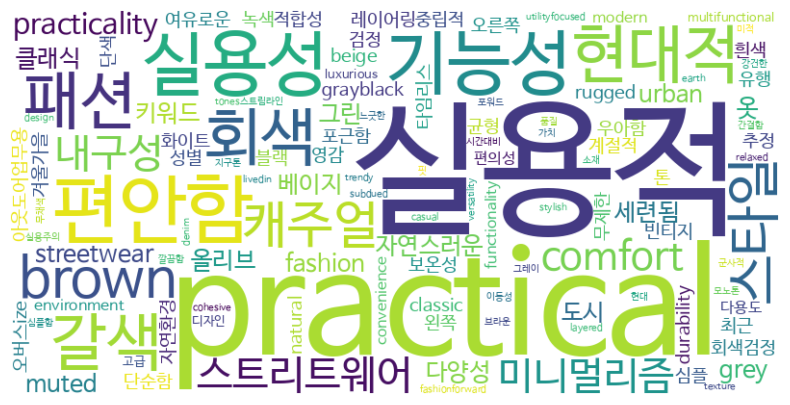

In [22]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def get_word_count(df):
    ## DataFrame의 'color'와 'keyword' 열에서 단어 빈도를 계산하는 함수
    if not df.empty:
        ## 'color' 열의 모든 단어를 리스트로 합침
        all_nouns = df['color'].apply(str.split).sum()
        ## 'keyword' 열의 모든 단어를 추가
        all_nouns += df['keyword'].apply(str.split).sum()
        ## '색상' 단어를 제외한 모든 단어를 필터링
        all_nouns = [word for word in all_nouns if word not in ['색상']]
        ## 단어 빈도를 Counter 객체로 반환
        return Counter(all_nouns)
    return Counter() ## DataFrame이 비어있으면 빈 Counter 반환

def create_wordcloud(word_count):
    ## 단어 빈도수를 기반으로 워드 클라우드를 생성하고 시각화하는 함수
    if not word_count: ## 단어 빈도가 없으면 워드클라우드 생성하지 않음
        print("No words to generate word cloud.")
        return

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' ## 한글 폰트 경로 지정
        ).generate_from_frequencies(word_count)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off") ## 축 표시 제거
    plt.show() ## 워드 클라우드 출력

## DataFrame에서 단어 빈도 계산
word_count = get_word_count(df)
## 계산된 단어 빈도로 워드 클라우드 생성 및 시각화
create_wordcloud(word_count)

## 14-14 트렌드 분석 보고서 생성 프롬프트 구성 및 실행

## 14-15 분석 보고서 시각화

In [25]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

## 시스템 메시지로 시작하는 프롬프트 리스트 초기화
prompt = [
    {
        "role": "system",
        "content": "You are EXAONE model from LG AI Research, a helpful assistant."
    }
]
## DataFrame의 각 행을 순회하며 '스타일 노트'와 '이미지 URL'을 사용자 메시지로 추가
for row in df.itertuples():
  prompt.append({"role": "user", "content": f"스타일 노트: {row.style}\n이미지 url:{row,image}"})
## 마지막으로, 종합적인 트렌드 분석 보고서 작성을 요청하는 사용자 메시지 추가
## 보고서 제목, 내용의 전문성, 마크다운 형식, 예시 이미지 포함을 지시
prompt.append({"role": "user", "content": "주어진 스타일 노트를 토대로 종합적인 트렌드 방향의 보고서를 작성해줘. 보고서의 제목은 해외 룩북 스타일 분석. 내용은 전문적이면서 명확하게. 문서 형식은 markdown으로"})

## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=4096)
## LLM 모델을 사용하여 구성된 프롬프트에 대한 응답 생성
result = llm.chat(prompt, sampling_params)[0].outputs[0].text

Processed prompts: 100%|██████████| 1/1 [00:21<00:00, 21.24s/it, est. speed input: 263.01 toks/s, output: 35.35 toks/s]


In [26]:
from IPython.display import display, Markdown

## LLM으로부터 생성된 결과(Markdown 형식의 보고서)를 Jupyter 환경에 표시
display(Markdown(result))

# 해외 룩북 스타일 분석 보고서

## 개요
본 보고서는 최근 발표된 여러 해외 패션 룩북 이미지들을 분석하여 현재 패션 트렌드의 주요 특징과 방향성을 종합적으로 조명합니다. 다양한 스타일과 색상 팔레트를 통해 현대 패션의 실용성과 미적 감각 사이의 균형을 탐구합니다.

## 트렌드 분석

### 1. **실용성과 편안함의 융합**
- **스타일 예시**: 
  - **캐주얼 및 스트리트웨어**: 
    - **스타일 노트**: 캐주얼한 아웃도어 재킷과 편안한 니트웨어의 조합은 도시 생활과 야외 활동 모두에 적합한 실용성을 강조합니다. (예: Index=5)
    - **키워드**: 캐주얼, 스트리트웨어, 실용적, 편안함, 기능성
  - **미니멀리즘**:
    - **스타일 노트**: 단순하고 기능적인 디자인의 의류는 현대적인 감각과 함께 일상 생활에서의 편안함을 제공합니다. (예: Index=7, Index=10)
    - **키워드**: 미니멀리즘, 현대적, 실용적, 간결함, 품질

### 2. **색상 팔레트의 다양성과 톤온톤**
- **색상 트렌드**:
  - **자연스러운 톤**: 베이지, 갈색, 회색 등 중립적인 색상 팔레트는 현대적인 세련됨을 표현합니다. (예: Index=6, Index=7, Index=10)
  - **모노톤**: 회색을 중심으로 한 모노톤 색상은 세련되고 모던한 이미지를 창출합니다. (예: Index=11)
  - **실용적 색상**: muted green, muted brown 등은 편안함과 실용성을 강조합니다. (예: Index=9)

### 3. **디자인 요소와 기능성의 결합**
- **디자인 특징**:
  - **실용적 디테일**: 여러 포켓, 내구성 있는 소재, 편안한 핏 등은 일상적인 활동에 최적화된 디자인을 보여줍니다. (예: Index=5, Index=7)
  - **기능적 레이어링**: 여러 레이어를 활용한 스타일링은 계절 변화에 유연하게 대응할 수 있는 능력을 강조합니다. (예: Index=6)

### 4. **브랜드 및 트렌드의 융합**
- **브랜드 영향**:
  - **군사적/실용적 스타일**: 강건한 소재와 기능성을 중시하는 디자인은 현대 스트리트웨어와 결합되어 새로운 트렌드를 형성합니다. (예: Index=7)
  - **고급스러운 스트리트웨어**: 프리미엄 소재와 브랜드 로고의 세련된 활용은 고급스러움과 트렌디함을 동시에 제공합니다. (예: Index=9)

## 결론
현재 패션 트렌드는 실용성과 미적 감각 사이의 균형을 중시하며, 다양한 색상 팔레트와 기능적인 디자인 요소를 통해 개인의 생활 스타일과 활동에 최적화된 의류를 제공하고 있습니다. 미니멀리즘과 스트리트웨어의 융합은 현대적인 감각을 유지하면서도 편안함과 세련됨을 동시에 추구하는 방향성을 보여줍니다. 이러한 트렌드는 소비자들이 일상 생활에서의 편안함과 동시에 스타일리시한 이미지를 유지할 수 있도록 돕고 있습니다.

---

이 보고서는 패션 전문가와 디자이너들에게 유용한 통찰력을 제공하며, 향후 컬렉션 개발 및 마케팅 전략 수립에 참고 자료로 활용될 수 있습니다.